<a href="https://colab.research.google.com/github/Aditya6122/Drone-View-Object-Detection/blob/main/(Custom_Backbone)_Working_Finetuning_on_object_detection_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!rm -rf /content/data_13
!cp -r /content/drive/MyDrive/Objectdetection/data_13 /content

In [ ]:
!rm -rf /content/data_13/.ipynb_checkpoints
!rm -rf /content/data_13/test/.ipynb_checkpoints
!rm -rf /content/data_13/train/.ipynb_checkpoints

In [ ]:
import os
from torch.utils.data import Dataset
from PIL import Image
import xml.etree.ElementTree as ET
import torch
from engine import train_one_epoch, evaluate
import random
import torch
import utils
from torchvision.transforms import functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.utils import draw_bounding_boxes
import transforms as T
from torchvision.models.detection import fasterrcnn_resnet50_fpn

In [ ]:
class CityDataset(Dataset):
    def __init__(self,root, transforms=None):
        self.root = root
        self.transforms = transforms
        self.imgs = list(sorted(os.listdir(os.path.join(root,"images"))))
        self.annots = list(sorted(os.listdir(os.path.join(root,"annotations"))))
        self.labels =   {
            'pedestrain':1,
            'tree':2,
            'car':3,
            'motorcycle':4
        }
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.root, "images", self.imgs[idx])
        annot_path = os.path.join(self.root, "annotations", self.annots[idx])
        img = Image.open(img_path).convert("RGB")
        tree = ET.parse(annot_path)
        root = tree.getroot()

        boxes = list()
        labels = list()
        for obj in root.findall('.//object'):
            label = obj.find('name').text
            box = obj.find('bndbox')
            xmin = int(box.find('xmin').text)
            ymin = int(box.find('ymin').text)
            xmax = int(box.find('xmax').text)
            ymax = int(box.find('ymax').text)
            coors = [xmin, ymin, xmax, ymax]
            boxes.append(coors)
            labels.append(self.labels[label])

        num_objs = len(labels)
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [ ]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [ ]:
def get_transform(train):
    transforms = []
    transforms.append(T.ToTensor())
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [ ]:

# !cp /content/drive/MyDrive/Objectdetection/image_classification/model_image_classification_mobilenet_v2.pt /content

In [ ]:
###################################### Using Custom MobileNet v2 as backbone ####################################

# import torchvision
# from torchvision.models.detection import FasterRCNN
# from torchvision.models.detection.rpn import AnchorGenerator
# import torch

# backbone = torchvision.models.mobilenet_v2(weights='DEFAULT')
# num_ftrs = backbone.classifier[1].in_features
# backbone.classifier[1] = torch.nn.Linear(num_ftrs,4)
# backbone.load_state_dict(torch.load('/content/model_image_classification_mobilenet_v2.pt'))
# backbone = backbone.features
# backbone.out_channels=1280

# anchor_generator = AnchorGenerator(sizes=((8,16,32,64,128)),
#                                    aspect_ratios=((0.125,0.25,0.5, 1.0),))
# roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0','1','2','3'],
#                                                 output_size=7,
#                                                 sampling_ratio=2)
# model = FasterRCNN(backbone,
#                    num_classes=5,
#                    rpn_anchor_generator=anchor_generator,
#                    box_roi_pool=roi_pooler)

In [ ]:
####################################### Using custom Resnet as backbone ############################################

# import torchvision
# from torchvision.models.detection import FasterRCNN
# from torchvision.models.detection.rpn import AnchorGenerator
# import torch

# backbone = torchvision.models.resnet18()
# num_ftrs = backbone.fc.in_features
# backbone.fc = torch.nn.Linear(num_ftrs, 4)
# backbone.load_state_dict(torch.load('/content/model_image_classification_resnet18.pt'))
# backbone_layers = list(backbone.children())[:-2] 
# backbone = torch.nn.Sequential(*backbone_layers)
# backbone.out_channels = 512

# anchor_generator = AnchorGenerator(sizes=((8,16,32,64,128)),
#                                    aspect_ratios=((0.125,0.25,0.5, 1.0),))
# roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0','1','2','3'],
#                                                 output_size=7,
#                                                 sampling_ratio=2)
# model = FasterRCNN(backbone,
#                    num_classes=5,
#                    rpn_anchor_generator=anchor_generator,
#                    box_roi_pool=roi_pooler)

In [ ]:
################################# Freezing the backbone parameters ################################

for name, param in model.named_parameters():
    if param.requires_grad and 'backbone' in name:
        param.requires_grad = False

In [ ]:
################################ Using mobilenet_v2 #######################################


import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
import torch

backbone = torchvision.models.mobilenet_v2(weights='DEFAULT').features
backbone.out_channels=1280

anchor_generator = AnchorGenerator(sizes=((8,16,32,64),),
                                   aspect_ratios=((0.25,0.5,1.0,2.0),))



roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0','1','3'],
                                                output_size=7,
                                                sampling_ratio=2)
model = FasterRCNN(backbone,
                   num_classes=5,
                   rpn_anchor_generator=anchor_generator,
                   box_roi_pool=roi_pooler)

In [ ]:

# model

In [ ]:
# ########################################## Using pretrained resnet50 #######################################

# import torchvision
# from torchvision.models.detection import FasterRCNN
# from torchvision.models.detection.rpn import AnchorGenerator
# import torch

# backbone = torchvision.models.resnet50(weights='DEFAULT')
# backbone_layers = list(backbone.children())[:-2] 
# backbone = torch.nn.Sequential(*backbone_layers)
# backbone.out_channels = 2048

# anchor_generator = AnchorGenerator(sizes=((8,16,32,64,128)),
#                                    aspect_ratios=((0.5, 1.0),))
# roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0','1'],
#                                                 output_size=7,
#                                                 sampling_ratio=2)
# model = FasterRCNN(backbone,
#                    num_classes=5,
#                    rpn_anchor_generator=anchor_generator,
#                    box_roi_pool=roi_pooler)

In [ ]:
# model

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

num_classes = 5

dataset = CityDataset('/content/data_13/train', get_transform(train=True))
dataset_test = CityDataset('/content/data_13/test', get_transform(train=False))

data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=8, shuffle=True, num_workers=4,
    collate_fn=collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=3, shuffle=False, num_workers=4,
    collate_fn=collate_fn)

model.to(device)

for name, param in model.named_parameters():
    if param.requires_grad and 'backbone' in name:
        param.requires_grad = False

param_backbone = [param for name,param in model.named_parameters() if param.requires_grad and 'backbone' in name]
param_other = [param for name,param in model.named_parameters() if param.requies_grad and 'backbone' not in name]
optimizer = torch.optim.SGD(params, lr=0.5, momentum=0.09, weight_decay=0.000005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=3, gamma=0.1)

num_epochs = 10

for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    lr_scheduler.step()
    evaluate(model, data_loader_test, device=device)


Epoch: [0]  [ 0/16]  eta: 0:00:30  lr: 0.033800  loss: 2.5147 (2.5147)  loss_classifier: 1.5932 (1.5932)  loss_box_reg: 0.0153 (0.0153)  loss_objectness: 0.6904 (0.6904)  loss_rpn_box_reg: 0.2158 (0.2158)  time: 1.9155  data: 1.2975  max mem: 10592
Epoch: [0]  [10/16]  eta: 0:00:03  lr: 0.366800  loss: 1.6287 (1.6958)  loss_classifier: 0.4295 (0.6710)  loss_box_reg: 0.0671 (0.0605)  loss_objectness: 0.4418 (0.4948)  loss_rpn_box_reg: 0.3926 (0.4695)  time: 0.6616  data: 0.1422  max mem: 10592
Epoch: [0]  [15/16]  eta: 0:00:00  lr: 0.500000  loss: 1.4603 (1.5962)  loss_classifier: 0.4295 (0.6375)  loss_box_reg: 0.0671 (0.0671)  loss_objectness: 0.3823 (0.4359)  loss_rpn_box_reg: 0.3979 (0.4556)  time: 0.6157  data: 0.1058  max mem: 10592
Epoch: [0] Total time: 0:00:09 (0.6224 s / it)
creating index...
index created!
Test:  [0/4]  eta: 0:00:01  model_time: 0.1519 (0.1519)  evaluator_time: 0.0044 (0.0044)  time: 0.4194  data: 0.2582  max mem: 10592
Test:  [3/4]  eta: 0:00:00  model_time: 

In [ ]:
import time

def get_inference(img_path,threshold,model):
    start = time.time()
    img = Image.open(img_path).convert("RGB")
    img = torchvision.transforms.PILToTensor()(img)
    print(img.size())

    model.eval()
    with torch.no_grad():
        prediction = model([(img/255).to(device)])
        
    labels =   {
            1:'person',
            2:'tree',
            3:'car',
            4:'motorcycle'
        }

    predictions = []
    for i in prediction[0]['labels'].tolist():
        predictions.append(labels[i])

    scores = prediction[0]['scores'].tolist()
    print(scores)
    idx = next(x for x, val in enumerate(scores) if val < threshold)
    output = draw_bounding_boxes(img.to(torch.uint8), prediction[0]['boxes'][:idx], predictions[:idx])
    out = torchvision.transforms.ToPILImage()(output) 
    end = time.time()
    time_taken = end-start
    return out,time_taken

torch.Size([3, 512, 512])
[0.6186040639877319, 0.5976627469062805, 0.5954278707504272, 0.5907920002937317, 0.5497593879699707, 0.510076105594635, 0.4945772588253021, 0.4677881896495819, 0.4630168676376343, 0.4594475030899048, 0.44417622685432434, 0.43930286169052124, 0.4296082556247711, 0.42409512400627136, 0.41590219736099243, 0.4058786928653717, 0.39275944232940674, 0.3684970438480377, 0.3652981221675873, 0.35724109411239624, 0.34118834137916565, 0.3400803506374359, 0.32758036255836487, 0.3272648751735687, 0.3268119990825653, 0.32298722863197327, 0.32296034693717957, 0.32168108224868774, 0.32090768218040466, 0.3187064528465271, 0.3177199959754944, 0.3168866038322449, 0.31369513273239136, 0.31335750222206116, 0.3119511604309082, 0.3116908371448517, 0.31133294105529785, 0.3109586834907532, 0.31045934557914734, 0.3100006878376007, 0.30952122807502747, 0.30763816833496094, 0.30711331963539124, 0.3048454225063324, 0.3028576076030731, 0.3026197850704193, 0.3023177981376648, 0.3012908399105

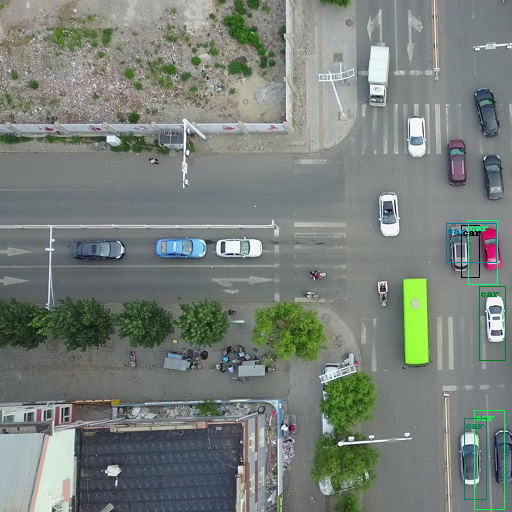

In [ ]:
img, time_taken = get_inference('/content/test1.jpg', 0.5, model)
print(time_taken)
img.show()

In [ ]:
torch.save(model.state_dict(), '/content/model_best_current.pt')

In [ ]:
# !cp /content/model_best_current.pt /content/drive/MyDrive/Objectdetection

In [ ]:
model1 = getDroneObjectDetectionInstance()
model1.load_state_dict(torch.load('/content/model_best_current.pt'))
model1.to(device)
model1.eval()

In [ ]:
video_path = '/content/video_preview_h264.mp4'

import cv2
vid = cv2.VideoCapture(video_path)

In [ ]:
labels =   {
        1:'person',
        2:'tree',
        3:'car',
        4:'motorcycle'
    }

In [ ]:
ret, frame = vid.read()

In [ ]:
video_path = '/content/video_preview_h264.mp4'
import cv2
vid = cv2.VideoCapture(video_path)

for ii in range(40):
    ret, frame = vid.read()
    orig_size = frame.shape
    frame = cv2.resize(frame, (512, 512))
    frame = torch.from_numpy(frame)
    frame = frame.permute(2, 0, 1)


    print(frame.size())

    model.eval()
    with torch.no_grad():
        prediction = model([(frame/255).to(device)])
        
    predictions = []
    for i in prediction[0]['labels'].tolist():
        predictions.append(labels[i])

    scores = prediction[0]['scores'].tolist()
    idx = next(x for x, val in enumerate(scores) if val < 0.6)
    output = draw_bounding_boxes(frame.to(torch.uint8), prediction[0]['boxes'][:idx], predictions[:idx])
    out = torchvision.transforms.ToPILImage()(output) 
    
    cv2.imshow(out)

torch.Size([3, 512, 512])


DisabledFunctionError: ignored